## Load data

In [113]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from dython.nominal import associations
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

random_state = 42

In [114]:
import warnings
warnings.filterwarnings("ignore")

In [115]:
from ucimlrepo import fetch_ucirepo 

census_income = fetch_ucirepo(id=20) 
df = census_income.data['original']

df['sex'] = df['sex'].apply(lambda x: 1 if x == 'Male' else 0)
df['income'] = df['income'].apply(lambda x: 1 if x.startswith('>50K') else 0)

_, df_test = train_test_split(df, test_size=0.2, random_state=random_state)

columns_to_drop = ["native-country", "education", "fnlwgt"]
df_test = df_test.drop(columns=columns_to_drop)

ModuleNotFoundError: No module named 'ucimlrepo'

In [116]:
# load the data
df = pd.read_csv("./data/synthetic_data.csv")
df_train, _ = train_test_split(df, test_size=0.2, random_state=random_state)

# Replace '?' with NaN, if necessary (check those special characters)
df_train.replace("?", np.nan, inplace=True)
df_test.replace("?", np.nan, inplace=True)

ratio_features = ["age", "capital-gain", "capital-loss", "hours-per-week"]
ordinal_features = [
    "education-num"
]  # 'education-num' is a numerical representation of 'education' ('education' will be removed)
nominal_features = [
    "workclass",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
]  # 'native-country' will be removed
target = "income"

df_train.drop_duplicates(inplace=True, ignore_index=True)
df_test.drop_duplicates(inplace=True, ignore_index=True)

columns_to_drop = ["native-country", "Unnamed: 0", "fnlwgt"]
df_train = df_train.drop(columns=columns_to_drop)
# df_test = df_test.drop(columns=columns_to_drop)
df_train.shape

(39073, 12)

## Clean data

In [117]:
def clean_data(X):
    X = X.reset_index(drop=True)
    X = X.drop(columns=["fnlwgt", "education"], errors="ignore")
    cols = list(X.columns)
    X[cols] = X[cols].replace([" ?"], np.nan)
    X = X.dropna()

    def strip_str(x):
        if isinstance(x, str):
            return x.strip()
        else:
            return x

    X = X.applymap(strip_str)
    X["relationship"] = X["relationship"].replace(["Husband", "Wife"], "Married")
    X["hours-per-week"] = pd.cut(
        x=X["hours-per-week"],
        bins=[0.9, 25, 39, 40, 55, 100],
        labels=["PartTime", "MidTime", "FullTime", "OverTime", "BrainDrain"],
    )
    X.age = pd.qcut(X.age, q=7)
    # X['artificial_feature'] = pd.qcut(X['artificial_feature'], q=5)
    X["capital-gain"] = pd.cut(
        X["capital-gain"],
        bins=[-1, 1, 1000, 5000, 10000, 100000, 1000000],
        labels=["None", "Low", "Medium", "High", "VeryHigh", "Rich"],
    )
    X["capital-loss"] = pd.cut(
        X["capital-loss"],
        bins=[-1, 1, 1000, 5000, 10000, 100000, 1000000],
        labels=["None", "Low", "Medium", "High", "VeryHigh", "Rich"],
    )
    return X

In [118]:
df_train_ = df_train.copy()
df_test_ = df_test.copy()
df_train_cleaned = clean_data(df_train_)
df_test_cleaned = clean_data(df_test_)

## Train baseline

In [183]:
def describe_model(y_test, y_pred, verbose=True):
    if verbose:
        print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
        print(f"Precision: {precision_score(y_test, y_pred, average='macro')}")
        print(f"Recall: {recall_score(y_test, y_pred, average='macro')}")
        print(f"F1: {f1_score(y_test, y_pred, average='macro')}")

    metrics = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='macro'),
        "Recall": recall_score(y_test, y_pred, average='macro'),
        "F1": f1_score(y_test, y_pred, average='macro')
    }
    return metrics

In [120]:
def split_data(df, target, drop_na=False):
    _df = df.copy()
    if drop_na:
        _df = _df.dropna()
    
    X = _df.drop(columns=[target])
    y = _df[target]

    return X, y

def train_and_evaluate(model, df_train, df_test, target, drop_na = False, sample_weight = None):
    X_train, y_train = split_data(df_train, target, drop_na)
    X_test, y_test = split_data(df_test, target, drop_na)

    if sample_weight is not None:
        model.fit(X_train, y_train, logisticregression__sample_weight=sample_weight)
    else:
        model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return y_test, y_pred

In [121]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

categorical_features_onehot_transformer = ColumnTransformer(
    transformers=[
        ("one-hot-encoder", OneHotEncoder(handle_unknown="ignore"), nominal_features),
    ],
    remainder="passthrough",
)

model = Pipeline(
    [
        ("one-hot-encoder", categorical_features_onehot_transformer),
        ("clf", LogisticRegression(max_iter=1000, random_state=random_state)),
    ]
)

In [122]:
y_test, y_pred = train_and_evaluate(model, df_train_, df_test_, target, drop_na=True)

In [123]:
describe_model(y_test, y_pred)

Accuracy: 0.8425914959137747
Precision: 0.814619788228803
Recall: 0.7955034907906182
F1: 0.8039590301649753


{'Accuracy': 0.8425914959137747,
 'Precision': 0.814619788228803,
 'Recall': 0.7955034907906182,
 'F1': 0.8039590301649753}

## Fairness Evaluation

In [124]:
features_4_scanning = nominal_features + ordinal_features + ratio_features

In [125]:
def print_report(data, subset):
    """Utility function to pretty-print the subsets."""
    if subset:
        to_choose = data[subset.keys()].isin(subset).all(axis=1)
        df = data[["income", "income-predicted"]][to_choose]
    else:
        for col in features_4_scanning:
            subset[col] = list(data[col].unique())
        df = data[["income", "income-predicted"]]

    true = df["income"].sum()
    pred = df["income-predicted"].sum()

    print("\033[1mSubset: \033[0m")
    print(subset)
    print("\033[1mSubset Size: \033[0m", len(df))
    print("\033[1mTrue Clicks: \033[0m", true)
    print("\033[1mPredicted Clicks: \033[0m", pred)
    print()

In [126]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

categorical_features_onehot_transformer = ColumnTransformer(
    transformers=[
        ("one-hot-encoder", OneHotEncoder(handle_unknown="ignore"), df_train_cleaned.select_dtypes(include=["object", "category"]).columns.to_list()),
    ],
    remainder="passthrough",
)

model = Pipeline(
    [
        ("one-hot-encoder", categorical_features_onehot_transformer),
        ("clf", LogisticRegression(max_iter=1000, random_state=random_state)),
    ]
)

In [127]:
from aif360.detectors.mdss.ScoringFunctions import Bernoulli
from aif360.detectors.mdss.MDSS import MDSS

to_delete = df_train_.copy()
to_delete.dropna(inplace=True)

to_delete = clean_data(to_delete)
_, y_pred = train_and_evaluate(model, to_delete, to_delete, target, drop_na=True)
to_delete["income-predicted"] = y_pred

# Bias scan
scoring_function = Bernoulli(direction="positive")
scanner = MDSS(scoring_function)

scanned_subset, _ = scanner.scan(
    to_delete[features_4_scanning],
    expectations=to_delete["income-predicted"],
    outcomes=to_delete["income"],
    penalty=1,
    num_iters=1,
    verbose=False,
)

print_report(to_delete, scanned_subset)

Subset: 
{'education-num': [3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15], 'relationship': ['Not-in-family', 'Other-relative', 'Own-child', 'Unmarried']}
Subset Size:  18899
True Clicks:  1685
Predicted Clicks:  406



In [128]:
import fairlens as fl

fscorer = fl.FairnessScorer(
    df_train_,
    target_attr="income",
    sensitive_attrs=scanned_subset.keys(),
)

fscorer.demographic_report()

ImportError: cannot import name 'binom_test' from 'scipy.stats' (/opt/homebrew/anaconda3/envs/testing/lib/python3.10/site-packages/scipy/stats/__init__.py)

In [129]:
from aif360.sklearn.detectors.facts import FACTS

X_train, y_train = split_data(df_train_, target, drop_na=True)
X_test, y_test = split_data(df_test_, target, drop_na=True)

# load FACTS framework with:
# - the model to be audited
# - protected attribute "sex" and
# - assigning equal, unit weights to all features for cost computation.
# - no features forbidden from changing, i.e. user can specify any features that cannot change at all.
detector = FACTS(
    clf=model,
    prot_attr=scanned_subset.keys(),
    feature_weights={f: 1 for f in X_train.columns},
    feats_not_allowed_to_change=[],
)

In [130]:
detector = detector.fit(X_train)

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [57]:
# Detects the top `top_count` most biased groups based on the given metric
# available metrics are:
# - equal-effectiveness
# - equal-choice-for-recourse
# - equal-effectiveness-within-budget
# - equal-cost-of-effectiveness
# - equal-mean-recourse
# - fair-tradeoff
# a short description for each metric is given below
detector.bias_scan(metric="equal-choice-for-recourse", phi=0.1, top_count=3)

In [ ]:
# prints the result into a nicely formatted report
detector.print_recourse_report(
    show_action_costs=False,
    show_subgroup_costs=True,
    show_unbiased_subgroups=False,
)

### Next evaluator

In [131]:
X_train, y_train = split_data(df_train_cleaned, target, drop_na=True)
model.fit(X_train, y_train)
probs = pd.Series(model.predict_proba(X_train)[:, 1])

In [132]:
from aif360.detectors.mdss_detector import bias_scan

privileged_subset = bias_scan(
    data=X_train,
    observations=y_train,
    scoring="Bernoulli",
    expectations=probs,
    overpredicted=True,
    penalty=1,
    alpha=0.24,
    favorable_value=1,
)

unprivileged_subset = bias_scan(
    data=X_train,
    observations=y_train,
    scoring="Bernoulli",
    expectations=probs,
    overpredicted=False,
    penalty=1,
    alpha=0.24,
    favorable_value=1
)

In [133]:
print(privileged_subset)
print(unprivileged_subset)

({'occupation': ['Adm-clerical', 'Exec-managerial', 'Other-service'], 'relationship': ['Not-in-family', 'Unmarried'], 'workclass': ['Private'], 'race': ['White']}, 13.8809)
({'education-num': [4, 14]}, 11.6045)


In [134]:
from aif360.sklearn.metrics import mdss_bias_score

mdss_bias_score(y_train, probs, X_train, subset=scanned_subset, pos_label=1, penalty=1)

-16.0

### Ignore

In [135]:
dff = X_train.copy()
dff["observed"] = y_train
dff["probabilities"] = probs.copy()

In [136]:
dff

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,observed,probabilities
0,"(43.0, 48.0]",Local-gov,6,Never-married,Transport-moving,Own-child,Black,1,None,None,FullTime,0,0.008118
1,"(55.0, 90.0]",State-gov,14,Married-civ-spouse,Prof-specialty,Married,White,1,High,None,FullTime,1,0.953614
2,"(43.0, 48.0]",Private,13,Never-married,Exec-managerial,Not-in-family,White,0,None,None,FullTime,0,0.225144
3,"(48.0, 55.0]",Federal-gov,11,Divorced,Machine-op-inspct,Unmarried,Black,0,None,None,FullTime,0,0.035731
4,"(43.0, 48.0]",Private,13,Married-civ-spouse,Prof-specialty,Married,White,1,None,None,FullTime,1,0.898192
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39068,"(30.0, 37.0]",Private,13,Married-civ-spouse,Exec-managerial,Married,White,1,None,None,FullTime,1,NaN
39069,"(55.0, 90.0]",Private,13,Married-civ-spouse,Machine-op-inspct,Married,White,1,None,Medium,OverTime,1,NaN
39070,"(37.0, 43.0]",Private,13,Married-civ-spouse,Tech-support,Married,Asian-Pac-Islander,1,None,None,OverTime,1,NaN
39071,"(25.0, 30.0]",Private,10,Married-civ-spouse,Sales,Married,White,1,None,None,FullTime,0,NaN


In [137]:
to_choose = dff[privileged_subset[0].keys()].isin(privileged_subset[0]).all(axis=1)
temp_df = dff.loc[to_choose]

"Our detected privileged group has a size of {}, we observe {} as the average probability of earning >50k, but our model predicts {}".format(
    len(temp_df),
    np.round(temp_df["observed"].mean(), 4),
    np.round(temp_df["probabilities"].mean(), 4),
)

'Our detected privileged group has a size of 2716, we observe 0.0898 as the average probability of earning >50k, but our model predicts 0.2988'

In [138]:
to_choose = dff[unprivileged_subset[0].keys()].isin(unprivileged_subset[0]).all(axis=1)
temp_df = dff.loc[to_choose]

"Our detected unprivileged group has a size of {}, we observe {} as the average probability of earning >50k, but our model predicts {}".format(
    len(temp_df),
    np.round(temp_df["observed"].mean(), 4),
    np.round(temp_df["probabilities"].mean(), 4),
)

'Our detected unprivileged group has a size of 4832, we observe 0.3909 as the average probability of earning >50k, but our model predicts 0.2918'

In [139]:
from aif360.sklearn.detectors import bias_scan
from aif360.sklearn.metrics import mdss_bias_score

priv_sub, priv_score = bias_scan(
    X_train, y_train, probs, pos_label=1, penalty=0.5, overpredicted=True
)
priv = df_train_[priv_sub.keys()].isin(priv_sub).all(axis=1)
priv_sub, priv_score

({'hours-per-week': ['PartTime', 'FullTime', 'BrainDrain'],
  'education-num': [7, 12, 15, 16],
  'marital-status': ['Married-civ-spouse', 'Never-married'],
  'capital-gain': ['None', 'Medium'],
  'age': [Interval(16.999, 25.0, closed='right'),
   Interval(25.0, 30.0, closed='right'),
   Interval(37.0, 43.0, closed='right'),
   Interval(48.0, 55.0, closed='right'),
   Interval(55.0, 90.0, closed='right')],
  'occupation': ['Craft-repair',
   'Exec-managerial',
   'Farming-fishing',
   'Handlers-cleaners',
   'Machine-op-inspct',
   'Prof-specialty',
   'Tech-support',
   'Transport-moving'],
  'race': ['Asian-Pac-Islander', 'Black', 'White'],
  'relationship': ['Married', 'Own-child', 'Unmarried']},
 17.0423)

In [140]:
print(f"Observed: {dff[priv].observed.mean():.2%}")
print(f"Expected: {dff[priv].probabilities.mean():.2%}")
print(f"n = {sum(priv)}")

priv_unpen = mdss_bias_score(
    y_train, probs, X=X_train, subset=priv_sub, pos_label=1, overpredicted=True, penalty=0
)
print(f"unpenalized score: {priv_unpen:.2f}")

Observed: nan%
Expected: nan%
n = 0
unpenalized score: 32.04


In [161]:
unpriv_sub, unpriv_score = bias_scan(
    X_train, y_train, probs, pos_label=1, penalty=0.5, overpredicted=False
)
unpriv = df_train_[unpriv_sub.keys()].isin(unpriv_sub).all(axis=1)
unpriv_sub, unpriv_score

/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/aif360/detectors/mdss/MDSS.py:57: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in temp_df.groupby(column_name):
/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/aif360/detectors/mdss/MDSS.py:57: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in temp_df.groupby(column_name):
/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/aif360/detectors/mdss/MDSS.py:57: FutureWarning: The default of observed=False is deprecated a

({'artificial_feature': [Interval(4.516, 9.081, closed='right')]}, 45382.2815)

In [162]:
print(f"Observed: {dff[unpriv].observed.mean():.2%}")
print(f"Expected: {dff[unpriv].probabilities.mean():.2%}")
print(f"n = {sum(unpriv)}")

unpriv_unpen = mdss_bias_score(
    y_train, probs, X=X_train, subset=unpriv_sub, pos_label=1, overpredicted=False, penalty=0
)
print(f"unpenalized score: {unpriv_unpen:.2f}")

Observed: 99.93%
Expected: 71.27%
n = 6893
unpenalized score: 45382.78


### Fairness Metrics

In [141]:
from aif360.sklearn.metrics import (
    equal_opportunity_difference,
    average_odds_difference,
    statistical_parity_difference,
    disparate_impact_ratio,
    theil_index,
)


def create_dataset(df, protected_attributes, priveleged_groups) -> pd.DataFrame:
    column_renaming = {}
    for i, col in enumerate(protected_attributes):
        df[f"{col}_index"] = df[col].copy()
        df[f"{col}"] = df[col].map(lambda x: 1 if x in priveleged_groups[i] else 0)
        column_renaming[f"{col}_index"] = f"{col}"

    if len(protected_attributes) > 0:
        df.set_index(protected_attributes, inplace=True)
        df = df.rename(columns=column_renaming)

    return df

def calculate_fairness_metrics(
    observed, predictions, protected_attributes, priveleged_group, sample_weights=None
):
    fairness_metrics = {}

    fairness_metrics["statistical_parity_difference"] = statistical_parity_difference(
        observed,
        predictions,
        prot_attr=protected_attributes,
        priv_group=priveleged_group,
        sample_weight=sample_weights
    )
    fairness_metrics["average_odds_difference"] = average_odds_difference(
        observed,
        predictions,
        prot_attr=protected_attributes,
        priv_group=priveleged_group,
        sample_weight=sample_weights
    )
    fairness_metrics["equal_opportunity_difference"] = equal_opportunity_difference(
        observed,
        predictions,
        prot_attr=protected_attributes,
        priv_group=priveleged_group,
        sample_weight=sample_weights
    )
    fairness_metrics["disparate_impact"] = disparate_impact_ratio(
        observed,
        predictions,
        prot_attr=protected_attributes,
        priv_group=priveleged_group,
        sample_weight=sample_weights
    )
    fairness_metrics["theil_index"] = theil_index(1 + predictions - observed)

    return fairness_metrics

In [142]:
df_train_bias = df_train_cleaned.copy()
df_test_bias = df_test_cleaned.copy()
df_train_bias.dropna(inplace=True)
df_test_bias.dropna(inplace=True)
df_train_bias = create_dataset(
    df_train_bias, list(privileged_subset[0].keys()), list(privileged_subset[0].values())
)
df_test_bias = create_dataset(
    df_test_bias, list(privileged_subset[0].keys()), list(privileged_subset[0].values())
)
df_train_bias.head(5)

age  education-num  \
occupation relationship workclass race                                
0          0            0         0     (43.0, 48.0]              6   
                                  1     (55.0, 90.0]             14   
1          1            1         1     (43.0, 48.0]             13   
0          1            0         0     (48.0, 55.0]             11   
           0            1         1     (43.0, 48.0]             13   

                                            marital-status  sex capital-gain  \
occupation relationship workclass race                                         
0          0            0         0          Never-married    1         None   
                                  1     Married-civ-spouse    1         High   
1          1            1         1          Never-married    0         None   
0          1            0         0               Divorced    0         None   
           0            1         1     Married-civ-spouse    1         None   

                                       capital-loss hours-per-week  income  \
occupation relationship workclass race                                       
0          0            0         0            None       FullTime       0   
                                  1            None       FullTime       1   
1          1            1         1            None       FullTime       0   
0          1            0         0            None       FullTime       0   
           0            1         1            None       FullTime       1   

                                               occupation   relationship  \
occupation relationship workclass race                                     
0          0            0         0      Transport-moving      Own-child   
                                  1        Prof-specialty        Married   
1          1            1         1       Exec-managerial  Not-in-family   
0          1            0         0     Machine-op-inspct      Unmarried   
           0            1         1        Prof-specialty        Married   

                                          workclass   race  
occupation relationship workclass race                      
0          0            0         0       Local-gov  Black  
                                  1       State-gov  White  
1          1            1         1         Private  White  
0          1            0         0     Federal-gov  Black  
           0            1         1         Private  White

In [143]:
train = df_train_bias.copy()
train.dropna(inplace=True)
X_train, y_train = train.drop(columns=[target], axis=1), train[target]
model = model.fit(X_train, y_train)

In [144]:
test = df_test_cleaned.copy()
X_test, y_test = test.drop(columns=[target]), test[target]
y_pred = model.predict(X_test)

print(f"Accuracy = {(y_test.values == y_pred).sum() / y_test.shape[0]:.2%}")

Accuracy = 84.76%


In [145]:
y_pred = model.predict(X_train)
metrics = calculate_fairness_metrics(
    df_train_bias[target], y_pred, list(privileged_subset[0].keys()), (1, 1, 1, 1)
)
metrics

{'statistical_parity_difference': 0.2618582309303959,
 'average_odds_difference': 0.33701286731331376,
 'equal_opportunity_difference': 0.5951431268530707,
 'disparate_impact': 15.816811566811568,
 'theil_index': 0.11555057242093832}

In [146]:
from aif360.datasets import StandardDataset


def convert_to_standard_dataset(df, protected_attributes, privileged_classes, target_label_name, scores_name=""):

    # List of names corresponding to protected attribute columns in the dataset.
    # Note that the terminology "protected attribute" used in AI Fairness 360 to
    # divide the dataset into multiple groups for measuring and mitigating
    # group-level bias.
    # protected_attributes = privileged_subset[0].keys()

    # columns from the dataset that we want to select for this Bias study
    selected_features = df.columns

    # This privileged class is selected based on MDSS subgroup evaluation.
    # in previous steps. In our case non-homeowner (homeowner=0) are considered to
    # be privileged and homeowners (homeowner=1) are considered as unprivileged.
    # privileged_classes = privileged_subset[0].values()

    # Label values which are considered favorable are listed. All others are
    # unfavorable. Label values are mapped to 1 (favorable) and 0 (unfavorable)
    # if they are not already binary and numerical.
    favorable_target_label = [1]

    # List of column names in the DataFrame which are to be expanded into one-hot vectors.
    categorical_features = nominal_features
    categorical_features = [
        col for col in categorical_features if col not in protected_attributes
    ]

    # create the `StandardDataset` object
    standard_dataset = StandardDataset(
        df=df,
        label_name=target_label_name,
        favorable_classes=favorable_target_label,
        scores_name=scores_name,
        protected_attribute_names=protected_attributes,
        privileged_classes=privileged_classes,
        categorical_features=categorical_features,
        # features_to_keep=selected_features
    )

    if scores_name == "":
        standard_dataset.scores = standard_dataset.labels.copy()

    return standard_dataset

In [147]:
# Metrics function
from collections import OrderedDict
from aif360.metrics import ClassificationMetric, BinaryLabelDatasetMetric


def compute_metrics(
    dataset_true, dataset_pred, unprivileged_groups, privileged_groups, disp=True
):
    """Compute the key metrics"""
    classified_metric_pred = ClassificationMetric(
        dataset_true,
        dataset_pred,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups,
    )
    metrics = OrderedDict()
    metrics["Statistical parity difference"] = (
        classified_metric_pred.statistical_parity_difference()
    )
    metrics["Disparate impact"] = classified_metric_pred.disparate_impact()
    metrics["Average odds difference"] = (
        classified_metric_pred.average_odds_difference()
    )
    metrics["Equal opportunity difference"] = (
        classified_metric_pred.equal_opportunity_difference()
    )
    metrics["Theil index"] = classified_metric_pred.theil_index()

    if disp:
        for k in metrics:
            print("%s = %.4f" % (k, metrics[k]))

    return metrics

In [149]:
df__ = df_train_.copy()  # pd.concat([df_train__, df_test__])
df__.reset_index(inplace=True, drop=True)
dataset_orig = convert_to_standard_dataset(df__, list(privileged_subset[0].keys()), list(privileged_subset[0].values()), target_label_name="income")

In [150]:
dataset_pred = dataset_orig.copy()
dataset_pred.labels = y_pred.reshape(-1, 1)
dataset_pred.scores = y_pred.reshape(-1, 1)

In [151]:
privileged_groups = [
    {"occupation": 1, 'relationship': 1, 'workclass': 1, 'race': 1}
]
unprivileged_groups = [
    {"occupation": 0, 'relationship': 0, 'workclass': 0, 'race': 0}
]
metrics2 = compute_metrics(
    dataset_orig, dataset_pred, unprivileged_groups, privileged_groups
)

Statistical parity difference = 0.1950
Disparate impact = 12.0333
Average odds difference = 0.2872
Equal opportunity difference = 0.4991
Theil index = 0.1156


In [152]:
metrics

{'statistical_parity_difference': 0.2618582309303959,
 'average_odds_difference': 0.33701286731331376,
 'equal_opportunity_difference': 0.5951431268530707,
 'disparate_impact': 15.816811566811568,
 'theil_index': 0.11555057242093832}

In [153]:
from aif360.detectors.mdss_detector import bias_scan

def iterate_it(df, model, penalty):
    _df = df.copy()
    X_train, y_train = split_data(_df, target, drop_na=True)
    model.fit(X_train, y_train)
    y_probs = pd.Series(model.predict_proba(X_train)[:, 1])

    privileged_subset = bias_scan(
        data=X_train,
        observations=y_train,
        scoring="Bernoulli",
        expectations=y_probs,
        overpredicted=True,
        penalty=penalty,
        alpha=0.24,
        favorable_value=1,
    )

    df_bias = df.copy()
    df_bias.dropna(inplace=True)

    df_bias = create_dataset(
        df_bias, list(privileged_subset[0].keys()), list(privileged_subset[0].values())
    )

    X_train, y_train = df_bias.drop(columns=[target], axis=1), df_bias[target]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_train)

    if len(privileged_subset[0].keys()) == 0:
        return {
            "statistical_parity_difference": 0,
             "average_abs_odds_difference": 0,
            "equal_opportunity_difference": 0,
            "disparate_impact": 0,
            "theil_index": 0,
        }, privileged_subset
    else:
        metrics = calculate_fairness_metrics(
            df_bias[target], y_pred, list(privileged_subset[0].keys()), (1,) * len(privileged_subset[0].keys())
        )
        return metrics, privileged_subset

In [154]:
df_bias = pd.DataFrame(
    columns=[
        "statistical_parity_difference",
        "average_abs_odds_difference",
        "equal_opportunity_difference",
        "disparate_impact",
        "theil_index",
    ]
)

for i in [1, 5, 10, 15, 20, 25, 50]:
    metrics, priv = iterate_it(df_train_cleaned, model, i)    
    df_bias.loc[f"penalty_{i}"] = metrics.values()

display(df_bias)

,statistical_parity_difference,average_abs_odds_difference,equal_opportunity_difference,disparate_impact,theil_index
penalty_1,0.261858,0.337013,0.595143,15.816812,0.115551
penalty_5,-0.493865,-0.305258,-0.221614,0.337772,0.115394
penalty_10,0.000000,0.000000,0.000000,0.000000,0.000000
penalty_15,0.000000,0.000000,0.000000,0.000000,0.000000
penalty_20,0.000000,0.000000,0.000000,0.000000,0.000000
penalty_25,0.000000,0.000000,0.000000,0.000000,0.000000
penalty_50,0.000000,0.000000,0.000000,0.000000,0.000000


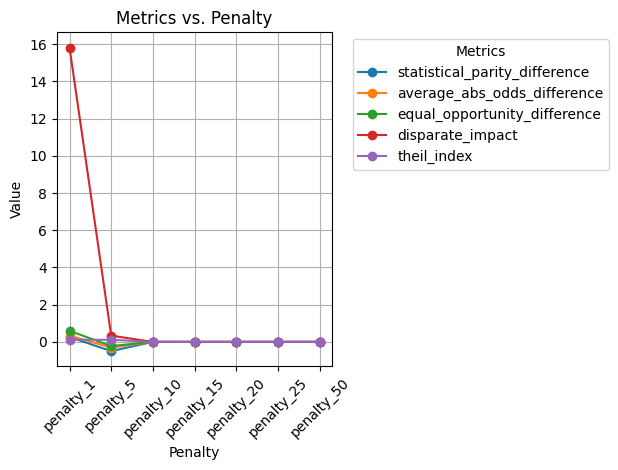

In [155]:
df_bias.plot(kind="line", marker='o')
plt.xlabel("Penalty")
plt.ylabel("Value")
plt.title("Metrics vs. Penalty")
plt.legend(title="Metrics", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

### Mitigation

#### Reweigthing

In [156]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

transformer = ColumnTransformer(
    transformers=[
        ("one-hot-encoder", OneHotEncoder(handle_unknown="ignore"), df_train_.select_dtypes(include=["object", "category"]).columns.to_list()),
    ],
    remainder="passthrough",
)

In [157]:
df_train__ = df_train_.copy()
df_test__ = df_test_.copy()
df_train__ = transformer.fit_transform(df_train__)
df_test__ = transformer.transform(df_test__)

In [158]:
# Combine train and test sets to fit the one-hot encoding
combined_df = pd.concat([df_train_, df_test_], keys=['train', 'test'])
combined_df.dropna(inplace=True)

# Apply one-hot encoding
combined_dummies = pd.get_dummies(combined_df, columns=df_train_.select_dtypes(include=["object", "category"]).columns.to_list())

# Split the combined encoded data back into train and test sets
df_train__ = combined_dummies.xs('train')
df_test__ = combined_dummies.xs('test')

# Ensure test set has all columns, filling missing columns with 0
df_test__ = df_test__.reindex(columns=df_train__.columns, fill_value=0)

In [159]:
from sklearn.linear_model import LogisticRegression

X_train, y_train = split_data(df_train__, target, True)
X_test, y_test = split_data(df_test__, target, True)

clf = LogisticRegression(verbose=False, max_iter=1250, random_state=random_state)
clf.fit(
    X_train,
    y_train,
    sample_weight=dataset_orig.instance_weights,
)
y_pred = clf.predict(X_test)
describe_model(y_test, y_pred)

Accuracy: 0.8412886414781475
Precision: 0.8143877076613131
Recall: 0.7908939161591644
F1: 0.8009982015008554


{'Accuracy': 0.8412886414781475,
 'Precision': 0.8143877076613131,
 'Recall': 0.7908939161591644,
 'F1': 0.8009982015008554}

In [162]:
privileged_groups = [
    {"occupation": 1, 'relationship': 1, 'workclass': 1, 'race': 1}
]
unprivileged_groups = [
    {"occupation": 0, 'relationship': 0, 'workclass': 0, 'race': 0}
]

df__ = df_train_.copy() 
df__.reset_index(inplace=True, drop=True)
dataset_orig = convert_to_standard_dataset(df__, list(privileged_subset[0].keys()), list(privileged_subset[0].values()), target_label_name="income")
y_pred = clf.predict(X_train)

dataset_pred = dataset_orig.copy()
dataset_pred.labels = y_pred.reshape(-1, 1)
dataset_pred.scores = y_pred.reshape(-1, 1)
metrics2 = compute_metrics(dataset_orig, dataset_pred, unprivileged_groups, privileged_groups)

Statistical parity difference = 0.2194
Disparate impact = 15.9001
Average odds difference = 0.3257
Equal opportunity difference = 0.5578
Theil index = 0.1195


In [163]:
from aif360.algorithms.preprocessing import Reweighing

RW = Reweighing(
    unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups
)

RW.fit(dataset_orig)
dataset_transf = RW.transform(dataset_orig)

In [164]:
clf = LogisticRegression(verbose=False, max_iter=1250, random_state=random_state)
clf.fit(
    X_train,
    y_train,
    sample_weight=dataset_transf.instance_weights,
)
y_pred = clf.predict(X_test)
describe_model(y_test, y_pred)

Accuracy: 0.8396304631055312
Precision: 0.8099786356675176
Recall: 0.7938878198919174
F1: 0.8011269901179868


{'Accuracy': 0.8396304631055312,
 'Precision': 0.8099786356675176,
 'Recall': 0.7938878198919174,
 'F1': 0.8011269901179868}

In [165]:
pred = clf.predict(X_train)

dataset_train_pred = dataset_transf.copy()
dataset_train_pred.labels = pred.reshape(-1, 1)
dataset_train_pred.scores = pred.reshape(-1, 1)

metrics = compute_metrics(
    dataset_transf, dataset_train_pred, unprivileged_groups, privileged_groups
)

Statistical parity difference = 0.1475
Disparate impact = 2.6433
Average odds difference = 0.2254
Equal opportunity difference = 0.4138
Theil index = 0.1170


Statistical parity difference = 0.2023

Disparate impact = 14.4043

Average odds difference = 0.3043

Equal opportunity difference = 0.5293

Theil index = 0.1161

In [270]:
from aif360.detectors.mdss.ScoringFunctions import Bernoulli
from aif360.detectors.mdss.MDSS import MDSS

to_delete = df_train_.copy()
to_delete.dropna(inplace=True)
# X_train, y_train = split_data(to_delete, drop_na=True)
# model.fit(X_train, y_train, clf__sample_weight=dataset_transf.instance_weights)
y_pred = clf.predict(X_train)
to_delete["income-predicted"] = y_pred

# Bias scan
scoring_function = Bernoulli(direction="negative")
scanner = MDSS(scoring_function)

scanned_subset, _ = scanner.scan(
    to_delete[features_4_scanning],
    expectations=to_delete["income-predicted"],
    outcomes=to_delete["income"],
    penalty=20,
    num_iters=1,
    verbose=False,
)

print_report(to_delete, scanned_subset)

Subset: 
{'occupation': ['Armed-Forces', 'Exec-managerial', 'Prof-specialty', 'Protective-serv', 'Sales', 'Tech-support'], 'relationship': ['Husband', 'Wife']}
Subset Size:  7870
True Clicks:  5991
Predicted Clicks:  7175



In [195]:
from aif360.detectors.mdss_detector import bias_scan

# split the data
X_train, y_train = split_data(df_train__, target, True)
X_test, y_test = split_data(df_test__, target, True)

def iterate(X_train, y_train, X_test, y_test, sample_weights=None):
    X, y = split_data(df_train_, target, True)
    clf = LogisticRegression(verbose=False, max_iter=1250, random_state=random_state)
    clf.fit(X_train, y_train, sample_weights)

    probs = pd.Series(clf.predict_proba(X_train)[:, 1])
    privileged_subset = bias_scan(
        data=X,
        observations=y,
        scoring="Bernoulli",
        expectations=probs,
        overpredicted=True,
        penalty=25,
        alpha=0.24,
        favorable_value=1,
    )

    if len(privileged_subset[0].keys()) <= 0:
        return None, None, None
    
    dataset_orig = convert_to_standard_dataset(
        df_train_,
        list(privileged_subset[0].keys()),
        list(privileged_subset[0].values()),
        target_label_name="income",
    )
    if sample_weights is not None:
        dataset_orig.instance_weights = sample_weights
    y_pred = clf.predict(X_train)

    dataset_pred = dataset_orig.copy()
    dataset_pred.labels = y_pred.reshape(-1, 1)
    dataset_pred.scores = y_pred.reshape(-1, 1)
    model_metrics = describe_model(y_test, clf.predict(X_test), False)

    privileged_groups = [{key: 1 for key in list(privileged_subset[0].keys())}]
    unprivileged_groups = [{key: 0 for key in list(privileged_subset[0].keys())}]

    df_train_bias = df_train_.copy()
    df_train_bias.dropna(inplace=True)
    df_train_bias = create_dataset(
        df_train_bias, list(privileged_subset[0].keys()), list(privileged_subset[0].values())
    )
    fair_metrics = calculate_fairness_metrics(df_train_bias[target], y_pred, list(privileged_subset[0].keys()), (1,) * len(privileged_subset[0].keys()))
    RW = Reweighing(
        unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups
    )

    RW.fit(dataset_orig)
    dataset = RW.transform(dataset_orig)
    return dataset.instance_weights, model_metrics, fair_metrics


df_bias = pd.DataFrame(
    columns=[
        "statistical_parity_difference",
        "average_abs_odds_difference",
        "equal_opportunity_difference",
        "disparate_impact",
        "theil_index",
    ]
)

df_metrics = pd.DataFrame(
    columns=['acc', 'prec', 'rec', 'f1']
)

weights = None

weights_hist = [None]
i = 0
while True:
    weights, model_metrics, fair_metrics = iterate(X_train, y_train, X_test, y_test, weights)
    if model_metrics is None:
        break

    df_metrics.loc[f"mitigation_{i}"] = model_metrics.values()
    df_bias.loc[f"mitigation_{i}"] = fair_metrics.values()
    weights_hist.append(weights)
    if i == 1 or i % 5 == 0:
        print(i, model_metrics)
        print(i, fair_metrics)

    i += 1
    if i > 500:
        break

0 {'Accuracy': 0.8412886414781475, 'Precision': 0.8143877076613131, 'Recall': 0.7908939161591644, 'F1': 0.8009982015008554}
0 {'statistical_parity_difference': -0.6024848773674618, 'average_odds_difference': -0.38265656594632, 'equal_opportunity_difference': -0.3270207633778318, 'disparate_impact': 0.2546736614446556, 'theil_index': 0.11948180666920727}


1 {'Accuracy': 0.8364325476726282, 'Precision': 0.8084132140730228, 'Recall': 0.7842503306022359, 'F1': 0.7945517854989097}
1 {'statistical_parity_difference': -0.33854998344559356, 'average_odds_difference': -0.2460977199359034, 'equal_opportunity_difference': -0.3387075549211197, 'disparate_impact': 0.31350146128997824, 'theil_index': 0.12499065124119975}


5 {'Accuracy': 0.8219827075683999, 'Precision': 0.7868190729639251, 'Recall': 0.7748758851105002, 'F1': 0.7803436147235323}
5 {'statistical_parity_difference': 0.17091986673120738, 'average_odds_difference': 0.04251896727230653, 'equal_opportunity_difference': 0.08372152114724052, 'disparate_impact': 1.900406254966404, 'theil_index': 0.12750206108590087}


10 {'Accuracy': 0.8247068577519839, 'Precision': 0.7902719819305495, 'Recall': 0.7781093296303712, 'F1': 0.7836774235543571}
10 {'statistical_parity_difference': 0.16763679327230785, 'average_odds_difference': 0.03992041771267546, 'equal_opportunity_difference': 0.08354940538455258, 'disparate_impact': 1.8719708544551266, 'theil_index': 0.12725881684947926}


15 {'Accuracy': 0.8165344072012318, 'Precision': 0.7790765100559229, 'Recall': 0.7724552445696853, 'F1': 0.7756008976714251}
15 {'statistical_parity_difference': 0.15602527613189648, 'average_odds_difference': 0.017549710300454657, 'equal_opportunity_difference': 0.0541196772771374, 'disparate_impact': 1.7610374768676447, 'theil_index': 0.12633194398491163}


20 {'Accuracy': 0.8155868767025939, 'Precision': 0.777779878816693, 'Recall': 0.7720239151444312, 'F1': 0.774775849668033}
20 {'statistical_parity_difference': 0.15463071289891536, 'average_odds_difference': 0.01467962012181484, 'equal_opportunity_difference': 0.049621652388042836, 'disparate_impact': 1.744952382729516, 'theil_index': 0.12557875894084178}


25 {'Accuracy': 0.8159422006395831, 'Precision': 0.7781882750463203, 'Recall': 0.7726319410868715, 'F1': 0.7752927916109085}
25 {'statistical_parity_difference': 0.1546311978987839, 'average_odds_difference': 0.015368308785141616, 'equal_opportunity_difference': 0.051201287382606875, 'disparate_impact': 1.7468348629867514, 'theil_index': 0.12588325404701758}


30 {'Accuracy': 0.8155868767025939, 'Precision': 0.777779878816693, 'Recall': 0.7720239151444312, 'F1': 0.774775849668033}
30 {'statistical_parity_difference': 0.15463071289891536, 'average_odds_difference': 0.01467962012181484, 'equal_opportunity_difference': 0.049621652388042836, 'disparate_impact': 1.744952382729516, 'theil_index': 0.12557875894084178}


35 {'Accuracy': 0.8159422006395831, 'Precision': 0.7781882750463203, 'Recall': 0.7726319410868715, 'F1': 0.7752927916109085}
35 {'statistical_parity_difference': 0.1546311978987839, 'average_odds_difference': 0.015368308785141616, 'equal_opportunity_difference': 0.051201287382606875, 'disparate_impact': 1.7468348629867514, 'theil_index': 0.12588325404701758}


40 {'Accuracy': 0.8155868767025939, 'Precision': 0.777779878816693, 'Recall': 0.7720239151444312, 'F1': 0.774775849668033}
40 {'statistical_parity_difference': 0.15463071289891536, 'average_odds_difference': 0.01467962012181484, 'equal_opportunity_difference': 0.049621652388042836, 'disparate_impact': 1.744952382729516, 'theil_index': 0.12557875894084178}


45 {'Accuracy': 0.8159422006395831, 'Precision': 0.7781882750463203, 'Recall': 0.7726319410868715, 'F1': 0.7752927916109085}
45 {'statistical_parity_difference': 0.1546311978987839, 'average_odds_difference': 0.015368308785141616, 'equal_opportunity_difference': 0.051201287382606875, 'disparate_impact': 1.7468348629867514, 'theil_index': 0.12588325404701758}


50 {'Accuracy': 0.8155868767025939, 'Precision': 0.777779878816693, 'Recall': 0.7720239151444312, 'F1': 0.774775849668033}
50 {'statistical_parity_difference': 0.15463071289891536, 'average_odds_difference': 0.01467962012181484, 'equal_opportunity_difference': 0.049621652388042836, 'disparate_impact': 1.744952382729516, 'theil_index': 0.12557875894084178}


55 {'Accuracy': 0.8159422006395831, 'Precision': 0.7781882750463203, 'Recall': 0.7726319410868715, 'F1': 0.7752927916109085}
55 {'statistical_parity_difference': 0.1546311978987839, 'average_odds_difference': 0.015368308785141616, 'equal_opportunity_difference': 0.051201287382606875, 'disparate_impact': 1.7468348629867514, 'theil_index': 0.12588325404701758}


60 {'Accuracy': 0.8155868767025939, 'Precision': 0.777779878816693, 'Recall': 0.7720239151444312, 'F1': 0.774775849668033}
60 {'statistical_parity_difference': 0.15463071289891536, 'average_odds_difference': 0.01467962012181484, 'equal_opportunity_difference': 0.049621652388042836, 'disparate_impact': 1.744952382729516, 'theil_index': 0.12557875894084178}


65 {'Accuracy': 0.8159422006395831, 'Precision': 0.7781882750463203, 'Recall': 0.7726319410868715, 'F1': 0.7752927916109085}
65 {'statistical_parity_difference': 0.1546311978987839, 'average_odds_difference': 0.015368308785141616, 'equal_opportunity_difference': 0.051201287382606875, 'disparate_impact': 1.7468348629867514, 'theil_index': 0.12588325404701758}


70 {'Accuracy': 0.8155868767025939, 'Precision': 0.777779878816693, 'Recall': 0.7720239151444312, 'F1': 0.774775849668033}
70 {'statistical_parity_difference': 0.15463071289891536, 'average_odds_difference': 0.01467962012181484, 'equal_opportunity_difference': 0.049621652388042836, 'disparate_impact': 1.744952382729516, 'theil_index': 0.12557875894084178}


75 {'Accuracy': 0.8159422006395831, 'Precision': 0.7781882750463203, 'Recall': 0.7726319410868715, 'F1': 0.7752927916109085}
75 {'statistical_parity_difference': 0.1546311978987839, 'average_odds_difference': 0.015368308785141616, 'equal_opportunity_difference': 0.051201287382606875, 'disparate_impact': 1.7468348629867514, 'theil_index': 0.12588325404701758}


80 {'Accuracy': 0.8155868767025939, 'Precision': 0.777779878816693, 'Recall': 0.7720239151444312, 'F1': 0.774775849668033}
80 {'statistical_parity_difference': 0.15463071289891536, 'average_odds_difference': 0.01467962012181484, 'equal_opportunity_difference': 0.049621652388042836, 'disparate_impact': 1.744952382729516, 'theil_index': 0.12557875894084178}


85 {'Accuracy': 0.8159422006395831, 'Precision': 0.7781882750463203, 'Recall': 0.7726319410868715, 'F1': 0.7752927916109085}
85 {'statistical_parity_difference': 0.1546311978987839, 'average_odds_difference': 0.015368308785141616, 'equal_opportunity_difference': 0.051201287382606875, 'disparate_impact': 1.7468348629867514, 'theil_index': 0.12588325404701758}


90 {'Accuracy': 0.8155868767025939, 'Precision': 0.777779878816693, 'Recall': 0.7720239151444312, 'F1': 0.774775849668033}
90 {'statistical_parity_difference': 0.15463071289891536, 'average_odds_difference': 0.01467962012181484, 'equal_opportunity_difference': 0.049621652388042836, 'disparate_impact': 1.744952382729516, 'theil_index': 0.12557875894084178}


95 {'Accuracy': 0.8159422006395831, 'Precision': 0.7781882750463203, 'Recall': 0.7726319410868715, 'F1': 0.7752927916109085}
95 {'statistical_parity_difference': 0.1546311978987839, 'average_odds_difference': 0.015368308785141616, 'equal_opportunity_difference': 0.051201287382606875, 'disparate_impact': 1.7468348629867514, 'theil_index': 0.12588325404701758}


100 {'Accuracy': 0.8155868767025939, 'Precision': 0.777779878816693, 'Recall': 0.7720239151444312, 'F1': 0.774775849668033}
100 {'statistical_parity_difference': 0.15463071289891536, 'average_odds_difference': 0.01467962012181484, 'equal_opportunity_difference': 0.049621652388042836, 'disparate_impact': 1.744952382729516, 'theil_index': 0.12557875894084178}


105 {'Accuracy': 0.8159422006395831, 'Precision': 0.7781882750463203, 'Recall': 0.7726319410868715, 'F1': 0.7752927916109085}
105 {'statistical_parity_difference': 0.1546311978987839, 'average_odds_difference': 0.015368308785141616, 'equal_opportunity_difference': 0.051201287382606875, 'disparate_impact': 1.7468348629867514, 'theil_index': 0.12588325404701758}


KeyboardInterrupt: 

In [196]:
df_bias.to_csv("df_bias_25.csv")
df_metrics.to_csv("df_metrics_25.csv")

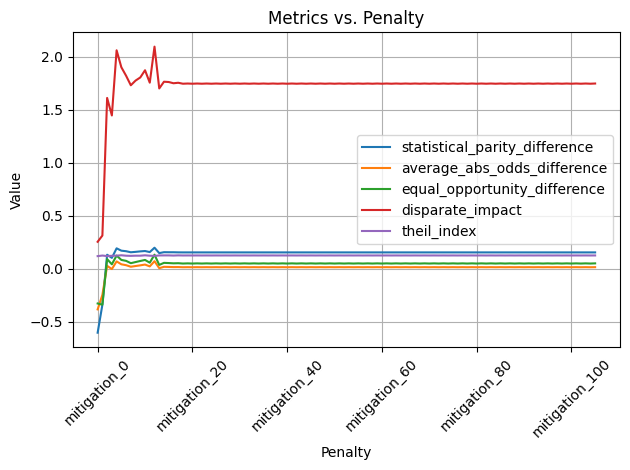

In [197]:
df_bias.plot(kind="line")
plt.xlabel("Penalty")
plt.ylabel("Value")
plt.title("Metrics vs. Penalty")
#plt.legend(title="Metrics", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

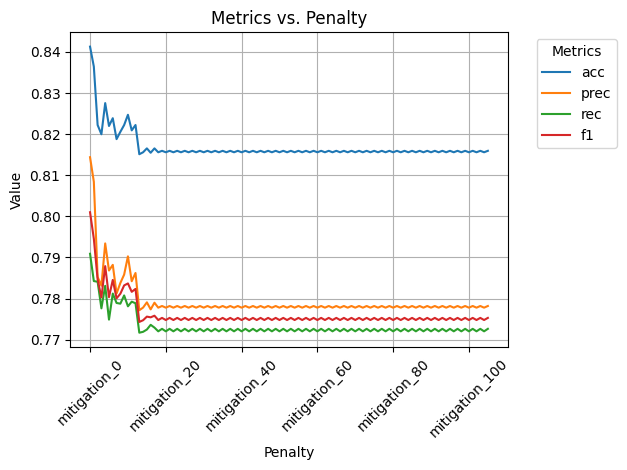

In [198]:
df_metrics.plot(kind="line")
plt.xlabel("Penalty")
plt.ylabel("Value")
plt.title("Metrics vs. Penalty")
plt.legend(title="Metrics", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

#### Fair Learning

In [123]:
import matplotlib.pyplot as plt
import pandas as pd

pd.set_option("display.max_columns", None)
import seaborn as sns
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression

from aif360.sklearn.datasets import fetch_adult
from aif360.sklearn.metrics import (
    make_scorer,
    statistical_parity_difference,
    consistency_score,
)
from aif360.sklearn.preprocessing import LearnedFairRepresentations

In [214]:
X_train, y_train = df_train_bias.drop(columns=["income"]), df_train_bias["income"]
X_test, y_test = df_test_bias.drop(columns=["income"]), df_test_bias["income"]
X_train.index = y_train.index = pd.MultiIndex.from_arrays(X_train.index.codes, names=X_train.index.names)
X_test.index = y_test.index = pd.MultiIndex.from_arrays(X_test.index.codes, names=X_test.index.names)
y_train = pd.Series(y_train.factorize(sort=True)[0], index=y_train.index, name=y_train.name)
y_test = pd.Series(y_test.factorize(sort=True)[0], index=y_test.index, name=y_test.name)

In [218]:
# Apply pd.get_dummies to both DataFrames
X_train_encoded = pd.get_dummies(X_train, columns=nominal_features)
X_test_encoded = pd.get_dummies(X_test, columns=nominal_features)

# Ensure both DataFrames have the same columns
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='outer', axis=1, fill_value=0)

# Optionally, you can reset the index to match the original DataFrames
X_train_encoded.index = X_train.index
X_test_encoded.index = X_test.index
X_train_encoded[X_train_encoded.columns] = X_train_encoded[X_train_encoded.columns].astype(int)
X_test_encoded[X_test_encoded.columns] = X_test_encoded[X_test_encoded.columns].astype(int)

In [219]:
from sklearn import metrics as skm


def discrimination(y_true, y_pred):
    return abs(
        statistical_parity_difference(
            y_true,
            y_pred,
            prot_attr=list(scanned_subset.keys()),
            priv_group=(1, 1, 1, 1),
        )
    )


def delta(y_true, y_pred, use_bal_acc=False):
    if use_bal_acc:
        return balanced_accuracy_score(
            y_true, y_pred
        )
    else:
        return accuracy_score(y_true, y_pred) - discrimination(y_true, y_pred)


min_disc = make_scorer(
    statistical_parity_difference,
    prot_attr=list(scanned_subset.keys()),
    priv_group=(1, 1, 1, 1),
)
max_delta = make_scorer(delta, use_bal_acc=False)

In [220]:
#X_train[X_train.columns] = X_train[X_train.columns].astype(int)
#X_test[X_test.columns] = X_test[X_test.columns].astype(int)
#X_train.head(5)

In [222]:
lfr = LearnedFairRepresentations(
    list(scanned_subset.keys()), n_prototypes=25, max_iter=100, random_state=random_state
)
params = {
    #"reconstruct_weight": [1e-2, 1e-3, 1e-4],
    "target_weight": [100, 1000],
    #"fairness_weight": [0, 100, 1000],
}

grid = GridSearchCV(lfr, params, scoring=max_delta, cv=3, n_jobs=-1).fit(
    X_train_encoded, y_train
)
res = pd.DataFrame(grid.cv_results_)
res

/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/aif360/sklearn/preprocessing/learning_fair_representations.py:163: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn('lbfgs failed to converge. Increase the number of '
/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/aif360/sklearn/preprocessing/learning_fair_representations.py:163: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn('lbfgs failed to converge. Increase the number of '
/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/aif360/sklearn/preprocessing/learning_fair_representations.py:163: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn('lbfgs failed to converge. Increase the number of '
/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_target_weight,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,6.943927,2.868794,0.026954,0.003422,100,{'target_weight': 100},-0.293350,-0.690165,-0.691750,-0.558421,0.187435,2
1,7.213204,0.291130,0.038939,0.013219,1000,{'target_weight': 1000},-0.267832,-0.332967,-0.298214,-0.299671,0.026611,1


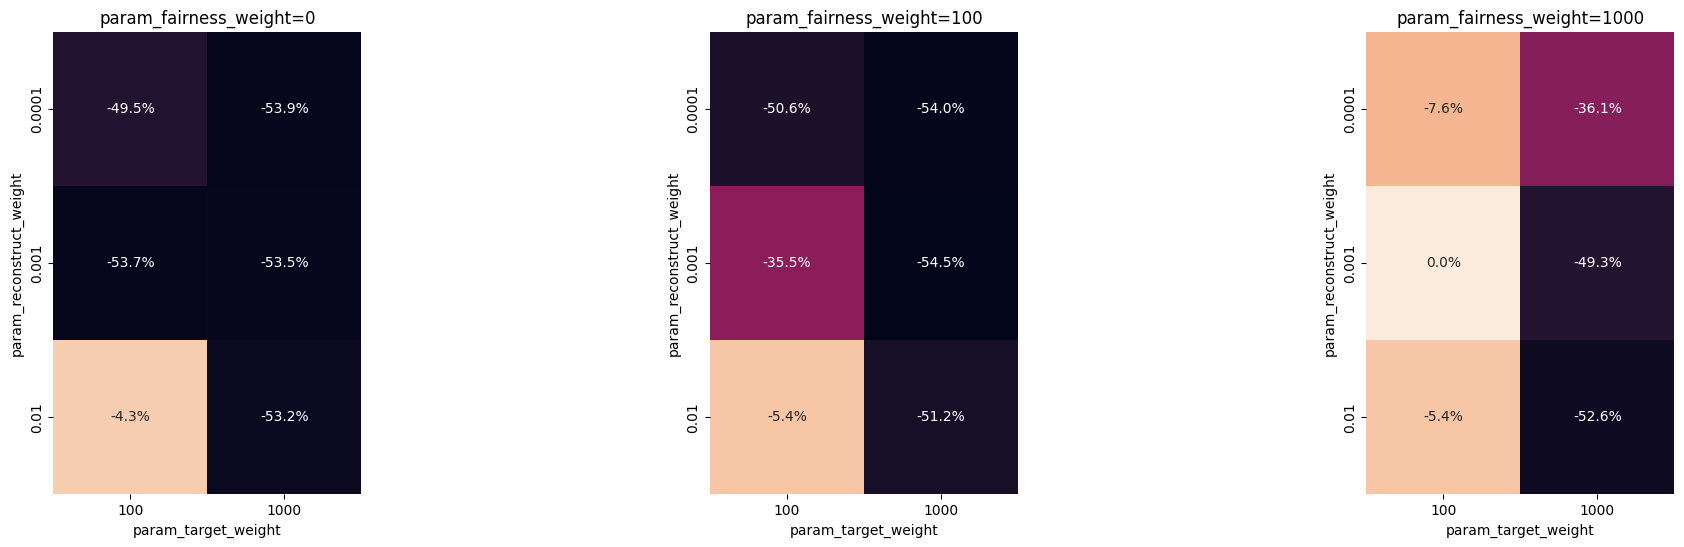

In [156]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'res' is your DataFrame and contains the columns mentioned
f, axes = plt.subplots(1, 3, squeeze=True, figsize=(24, 6))
by_fair = res.set_index("param_fairness_weight")

for ax, r in zip(axes, by_fair.index.unique()):
    pivot_table = by_fair.xs(r).pivot(
        index="param_reconstruct_weight",
        columns="param_target_weight",
        values="mean_test_score",
    )
    sns.heatmap(
        pivot_table,
        annot=True,
        fmt=".1%",
        vmin=res["mean_test_score"].min(),
        vmax=res["mean_test_score"].max(),
        square=True,
        cbar=False,
        ax=ax,
    )
    ax.set_title("param_fairness_weight={}".format(r))

plt.show()

In [234]:
y_pred_lfr = grid.predict(X_test_encoded)
mlp = MLPClassifier(max_iter=1000, random_state=random_state)
y_pred_lr = mlp.fit(X_train_encoded, y_train).predict(X_test_encoded)
y_pred_lfr_lr = mlp.fit(grid.transform(X_train_encoded), y_train).predict(X_train_encoded)

In [235]:
print("accuracy_score:", skm.accuracy_score(y_test, y_pred_lfr_lr))
calculate_fairness_metrics(
    y_train,
    y_pred_lfr_lr,
    list(scanned_subset.keys()),
    (1, 1, 1, 1),
)

accuracy_score: 0.7064012535546399


{'statistical_parity_difference': 0.00019728168311800904,
 'average_odds_difference': 3.84052620502079e-06,
 'equal_opportunity_difference': 8.592325106086574e-05,
 'disparate_impact': 1.7765993455940425,
 'theil_index': 0.34726915099741223}

In [ ]:
from aif360.detectors.mdss.ScoringFunctions import Bernoulli
from aif360.detectors.mdss.MDSS import MDSS

# Bias scan
scoring_function = Bernoulli(direction="negative")
scanner = MDSS(scoring_function)

to_delete = grid.transform(X_train_encoded)
to_delete['income'] = y_train
to_delete.reset_index(drop=True, inplace=True)
to_delete["income_predicted"] = y_pred_lfr_lr

scanned_subset, _ = scanner.scan(
    to_delete[['age', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week', 'workclass_Federal-gov', 'workclass_Local-gov',
       'workclass_Never-worked', 'workclass_Private', 'workclass_Self-emp-inc',
       'workclass_Self-emp-not-inc', 'workclass_State-gov',
       'workclass_Without-pay', 'marital-status_Divorced',
       'marital-status_Married-AF-spouse', 'marital-status_Married-civ-spouse',
       'marital-status_Married-spouse-absent', 'marital-status_Never-married',
       'marital-status_Separated', 'marital-status_Widowed',
       'occupation_Adm-clerical', 'occupation_Armed-Forces',
       'occupation_Craft-repair', 'occupation_Exec-managerial',
       'occupation_Farming-fishing', 'occupation_Handlers-cleaners',
       'occupation_Machine-op-inspct', 'occupation_Other-service',
       'occupation_Priv-house-serv', 'occupation_Prof-specialty',
       'occupation_Protective-serv', 'occupation_Sales',
       'occupation_Tech-support', 'occupation_Transport-moving',
       'relationship_Husband', 'relationship_Not-in-family',
       'relationship_Other-relative', 'relationship_Own-child',
       'relationship_Unmarried', 'relationship_Wife',
       'race_Amer-Indian-Eskimo', 'race_Asian-Pac-Islander', 'race_Black',
       'race_Other', 'race_White', 'sex_0', 'sex_1']],
    expectations=to_delete["income_predicted"],
    outcomes=to_delete["income"],
    penalty=1,
    num_iters=5,
    verbose=False,
)

In [248]:
scanned_subset

{'race_White': [-1.4940858420301346,
  -1.4507764368482199,
  -1.425120943986268,
  -1.4228516491412095,
  -1.4165189856355629,
  -1.394822877159016,
  -1.3857954340299983,
  -1.3343289380941001,
  -0.2520143752041035,
  -0.24962289612893734,
  -0.13479522669967495,
  -0.12176589894629879]}

In [265]:
X_train2 = grid.transform(X_train_encoded)
X_test2 = grid.transform(X_test_encoded)

X_train2 = create_dataset(X_train2, list(scanned_subset.keys()), list(scanned_subset.values()))
X_test2 = create_dataset(X_test2, list(scanned_subset.keys()), list(scanned_subset.values()))

y_train.index = X_train2.index
y_test.index = X_test2.index
y_train = pd.Series(y_train.factorize(sort=True)[0], index=y_train.index, name=y_train.name)
y_test = pd.Series(y_test.factorize(sort=True)[0], index=y_test.index, name=y_test.name)

from sklearn import metrics as skm


def discrimination(y_true, y_pred):
    return abs(
        statistical_parity_difference(
            y_true,
            y_pred,
            prot_attr=list(scanned_subset.keys()),
            priv_group=(1),
        )
    )


def delta(y_true, y_pred, use_bal_acc=False):
    if use_bal_acc:
        return balanced_accuracy_score(
            y_true, y_pred
        )
    else:
        return accuracy_score(y_true, y_pred) - discrimination(y_true, y_pred)


min_disc = make_scorer(
    statistical_parity_difference,
    prot_attr=list(scanned_subset.keys()),
    priv_group=(1),
)
max_delta = make_scorer(delta, use_bal_acc=False)

lfr = LearnedFairRepresentations(
    list(scanned_subset.keys()), n_prototypes=25, max_iter=100, random_state=random_state
)
params = {
    #"reconstruct_weight": [1e-2, 1e-3, 1e-4],
    "target_weight": [100, 1000],
    #"fairness_weight": [0, 100, 1000],
}

grid = GridSearchCV(lfr, params, scoring=max_delta, cv=3, n_jobs=-1).fit(
    X_train2, y_train
)
res = pd.DataFrame(grid.cv_results_)
res

/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/aif360/sklearn/preprocessing/learning_fair_representations.py:163: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn('lbfgs failed to converge. Increase the number of '
/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/aif360/sklearn/preprocessing/learning_fair_representations.py:163: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn('lbfgs failed to converge. Increase the number of '
/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/aif360/sklearn/preprocessing/learning_fair_representations.py:163: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn('lbfgs failed to converge. Increase the number of '
/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_target_weight,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,5.580613,0.680525,0.025025,0.006776,100,{'target_weight': 100},-0.512614,-0.513725,-0.525524,-0.517288,0.005842,1
1,5.894981,0.112362,0.013416,0.000721,1000,{'target_weight': 1000},-0.512091,-0.515467,-0.524479,-0.517345,0.005229,2


In [267]:
y_pred_lfr = grid.predict(X_test2)
mlp = MLPClassifier(max_iter=1000, random_state=random_state)
y_pred_lr = mlp.fit(X_train2, y_train).predict(X_test2)
y_pred_lfr_lr = mlp.fit(grid.transform(X_train2), y_train).predict(X_test2)

In [270]:
print("accuracy_score:", skm.accuracy_score(y_test, y_pred_lfr_lr))
calculate_fairness_metrics(
    y_train,
    y_pred_lfr_lr,
    list(scanned_subset.keys()),
    (1),
)

accuracy_score: 0.7095931750914051


/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Ratio is ill-defined and being set to 0.0 due to no predicted privileged samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

{'statistical_parity_difference': 0.15152394775036285,
 'average_odds_difference': 0.18416295854252343,
 'equal_opportunity_difference': 0.2631578947368421,
 'disparate_impact': 0.0,
 'theil_index': 0.27296280570120457}

In [272]:
from aif360.detectors.mdss.ScoringFunctions import Bernoulli
from aif360.detectors.mdss.MDSS import MDSS

# Bias scan
scoring_function = Bernoulli(direction="negative")
scanner = MDSS(scoring_function)

to_delete = grid.transform(X_train2)
to_delete['income'] = y_train
to_delete.reset_index(drop=True, inplace=True)
to_delete["income_predicted"] = y_pred_lfr_lr

scanned_subset, _ = scanner.scan(
    to_delete[['age', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week', 'workclass_Federal-gov', 'workclass_Local-gov',
       'workclass_Never-worked', 'workclass_Private', 'workclass_Self-emp-inc',
       'workclass_Self-emp-not-inc', 'workclass_State-gov',
       'workclass_Without-pay', 'marital-status_Divorced',
       'marital-status_Married-AF-spouse', 'marital-status_Married-civ-spouse',
       'marital-status_Married-spouse-absent', 'marital-status_Never-married',
       'marital-status_Separated', 'marital-status_Widowed',
       'occupation_Adm-clerical', 'occupation_Armed-Forces',
       'occupation_Craft-repair', 'occupation_Exec-managerial',
       'occupation_Farming-fishing', 'occupation_Handlers-cleaners',
       'occupation_Machine-op-inspct', 'occupation_Other-service',
       'occupation_Priv-house-serv', 'occupation_Prof-specialty',
       'occupation_Protective-serv', 'occupation_Sales',
       'occupation_Tech-support', 'occupation_Transport-moving',
       'relationship_Husband', 'relationship_Not-in-family',
       'relationship_Other-relative', 'relationship_Own-child',
       'relationship_Unmarried', 'relationship_Wife',
       'race_Amer-Indian-Eskimo', 'race_Asian-Pac-Islander', 'race_Black',
       'race_Other', 'race_White', 'sex_0', 'sex_1']],
    expectations=to_delete["income_predicted"],
    outcomes=to_delete["income"],
    penalty=1,
    num_iters=5,
    verbose=False,
)

scanned_subset

{'race_White': [0.18668670341085353,
  0.187589890436231,
  0.1880333446196287,
  0.18939922454240374,
  0.18941839031871355,
  0.19001306821229888,
  0.1904715363970188,
  0.1906432236239819,
  0.19124938660339966,
  0.1918050772717629,
  0.19242081288688806,
  0.194304870722789,
  0.19438594086217587,
  0.19447122485432985,
  0.1946499468611636,
  0.19490307743901833,
  0.19521652458259123,
  0.19547013530742613,
  0.1958760960052867,
  0.1963393568553801,
  0.196998882166027,
  0.19716140384151848,
  0.19741337478874493,
  0.19938433974013206,
  0.38329574836990205,
  0.3848468047586279,
  0.41043416350900014,
  0.4162612987554364,
  0.4240168336265145,
  0.42656447026454575,
  0.43219869051450965,
  0.4334367041394699,
  0.4468642054407333,
  0.4519720383237177,
  0.4542963339693122,
  0.4553508353441075,
  0.4562426487288802,
  0.46027378134472485,
  0.46230602367592316,
  0.46508886469592037,
  0.4652489643261995,
  0.4668069828084948,
  0.4684892551915445,
  0.469158912319415,
 

#### Fair Adapt

In [399]:
X_train, y_train = split_data(df_train_bias, drop_na=True)
X_test, y_test = split_data(df_test_bias, drop_na=True)

In [400]:
df_train = pd.concat([X_train, y_train], axis=1)

adj_mat = pd.DataFrame(
    np.zeros((len(df_train.columns), len(df_train.columns)), dtype=int),
    index=df_train.columns.values,
    columns=df_train.columns.values,
)

# Construct the adjacency matrix of the causal graph
adj_mat.loc[
    ["sex", "age", "race"],
    [
        "marital-status",
        "education-num",
        "workclass",
        "hours-per-week",
        "occupation",
        "income",
    ],
] = 1
adj_mat.loc[
    "marital-status",
    ["education-num", "workclass", "hours-per-week", "occupation", "income"],
] = 1
adj_mat.loc[
    "education-num", ["workclass", "hours-per-week", "occupation", "income"]
] = 1
adj_mat.loc[["workclass", "hours-per-week", "occupation"], "income"] = 1

In [403]:
from aif360.sklearn.preprocessing import FairAdapt

FA = FairAdapt(prot_attr=list(scanned_subset.keys()), adj_mat=adj_mat)
Xf_train, yf_train, Xf_test = FA.fit_transform(X_train, y_train, X_test)

ValueError: Expected 2 protected attribute groups, got Index([(0, 0, 0), (1, 1, 0), (1, 0, 1), (0, 0, 1), (0, 1, 0), (1, 0, 0),
       (0, 1, 1), (1, 1, 1)],
      dtype='object')

In [104]:
from sklearn.pipeline import Pipeline

categorical_features_onehot_transformer = ColumnTransformer(
    transformers=[
        ("one-hot-encoder", OneHotEncoder(handle_unknown="ignore"), nominal_features),
    ],
    remainder="passthrough",
)

model = Pipeline(
    [
        ("one-hot-encoder", categorical_features_onehot_transformer),
        ("clf", MLPClassifier(verbose=False, max_iter=25, random_state=random_state)),
    ]
)

In [105]:
Xf_train["artificial_feature"] = Xf_train["artificial_feature"].astype(int)
Xf_test["artificial_feature"] = Xf_test["artificial_feature"].astype(int)

In [106]:
y_pred_lr = model.fit(X_train, y_train).predict(X_test)
y_pred_lfr_lr = model.fit(Xf_train, yf_train).predict(Xf_test)

/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


In [107]:
add_row(
    df_utility,
    "fair_adapt_dataset_mitigated",
    [
        accuracy_score(y_test, y_pred_lfr_lr),
        precision_score(y_test, y_pred_lfr_lr, average="macro"),
        recall_score(y_test, y_pred_lfr_lr, average="macro"),
        f1_score(y_test, y_pred_lfr_lr, average="macro"),
    ],
)

In [143]:
print(
    "statistical_parity_difference: ",
    statistical_parity_difference(
        y_test, y_pred_lr, prot_attr=["artificial_feature"], priv_group=(1)
    ),
)
print(
    "average_odds_difference: ",
    average_odds_difference(
        y_test, y_pred_lr, prot_attr=["artificial_feature"], priv_group=(1)
    ),
)
print(
    "equal_opportunity_difference: ",
    equal_opportunity_difference(
        y_test, y_pred_lr, prot_attr=["artificial_feature"], priv_group=(1)
    ),
)
print(
    "average_odds_error:",
    average_odds_error(
        y_test, y_pred_lr, prot_attr=["artificial_feature"], priv_group=(1)
    ),
)
print(
    "disperate impact",
    disparate_impact_ratio(
        y_test, y_pred_lr, prot_attr=["artificial_feature"], priv_group=(1)
    ),
)
print("theil_index", theil_index(1 + y_pred_lr - y_test))

statistical_parity_difference:  0.6801083495345629
average_odds_difference:  0.48823794734362436
equal_opportunity_difference:  0.6421279937180998
average_odds_error: 0.48823794734362436
disperate impact 160.2999238705274
theil_index 0.07313420925170272


In [137]:
print(
    "statistical_parity_difference: ",
    statistical_parity_difference(
        y_test, y_pred_lfr_lr, prot_attr=["artificial_feature"], priv_group=(1)
    ),
)
print(
    "average_odds_difference: ",
    average_odds_difference(
        y_test, y_pred_lfr_lr, prot_attr=["artificial_feature"], priv_group=(1)
    ),
)
print(
    "equal_opportunity_difference: ",
    equal_opportunity_difference(
        y_test, y_pred_lfr_lr, prot_attr=["artificial_feature"], priv_group=(1)
    ),
)
print(
    "average_odds_error:",
    average_odds_error(
        y_test, y_pred_lfr_lr, prot_attr=["artificial_feature"], priv_group=(1)
    ),
)
print(
    "disperate impact",
    disparate_impact_ratio(
        y_test, y_pred_lfr_lr, prot_attr=["artificial_feature"], priv_group=(1)
    ),
)
print("theil_index", theil_index(1 + y_pred_lfr_lr - y_test))

statistical_parity_difference:  0.39558843876372324
average_odds_difference:  -0.045598145922633504
equal_opportunity_difference:  -0.08244994110718495
average_odds_error: 0.045598145922633504
disperate impact 2.0512982078130304
theil_index 0.0803769807750931


In [139]:
add_row(
    df_bias,
    "dataset_with_fairAdapt_mitigation",
    [
        statistical_parity_difference(
            y_test, y_pred_lfr_lr, prot_attr=["artificial_feature"], priv_group=(1)
        ),
        disparate_impact_ratio(
            y_test, y_pred_lfr_lr, prot_attr=["artificial_feature"], priv_group=(1)
        ),
        equal_opportunity_difference(
            y_test, y_pred_lfr_lr, prot_attr=["artificial_feature"], priv_group=(1)
        ),
        average_odds_difference(
            y_test, y_pred_lfr_lr, prot_attr=["artificial_feature"], priv_group=(1)
        ),
        theil_index(1 + y_pred_lfr_lr - y_test),
    ],
)

In [117]:
describe_model(y_test, y_pred_lr)

Accuracy: 0.9044800371402043
Precision: 0.8912866151954673
Recall: 0.8763460554115201
F1: 0.8832939497325631


In [118]:
describe_model(y_test, y_pred_lfr_lr)

Accuracy: 0.7122794800371403
Precision: 0.7277874987111761
Recall: 0.7717533272359768
F1: 0.703881218446319
